pwd

In [1]:
cd D:\sjsu semesters\New folder\Neural Networks\Projects\cifar-10-batches-py

D:\sjsu semesters\New folder\Neural Networks\Projects\cifar-10-batches-py


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
#cifar10_dataset_folder_path ='D:\sjsu semesters\New folder\Neural Networks\Projects\cifar-10-batches-py'
def load_cfar10_batch(batch_id):
    with open('data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data']
    labels = batch['labels']
        
    return features, labels

In [5]:
#path = 'D:\sjsu semesters\New folder\Neural Networks\Projects\cifar-10-batches-py'
path = ''
features, labels = load_cfar10_batch(1)

In [6]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets(df, one_hot=True)

In [7]:
features.shape

(10000, 3072)

In [8]:
features

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [9]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [10]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [11]:


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open('test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data']
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')



learning_pace = 0.001
training_epochs = 15
batch_size = 100
display_step = 1


In [12]:
preprocess_and_save_data(normalize, one_hot_encode)

In [13]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [14]:
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 3072), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

def multilayer_perceptron(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [32]:
def multilayer_perceptron(x,n):
    full1 = tf.contrib.layers.fully_connected(inputs=x, num_outputs=n*8, activation_fn=tf.nn.tanh)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=n*4, activation_fn=tf.nn.tanh)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=n*2, activation_fn=tf.nn.tanh)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=n, activation_fn=tf.nn.tanh)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)
    
    out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return out

In [16]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.00005

n_hidden_1 = 8 # 1st layer number of neurons
n_hidden_2 = 8 # 2nd layer number of neurons
n_input = 3072
n_classes = 10

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

logits = multilayer_perceptron(x,n)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [17]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [18]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [19]:
def return_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    return loss, valid_acc

In [20]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [33]:
from datetime import datetime
save_model_path = './image_classification'
Train_time_list_10ep=[]
epoch_val=[]
accuracy_values=[]
losss_values = []
print('Training...')
for n in [1,2,4,6,8,10,12,14,16,18,20,25,32,64,96,108,128,256,512]:
    logits = multilayer_perceptron(x,n)
    model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        start=datetime.now()
        # Training cycle
        for epoch in range(epochs):
            # Loop over all batches
            n_batches = 5
            for batch_i in range(1, n_batches + 1):
                for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                Train_elapse = (datetime.now()-start).total_seconds()
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_stats(sess, batch_features, batch_labels, cost, accuracy)
                print(Train_elapse)
                losss,accuracys=return_stats(sess, batch_features, batch_labels, cost, accuracy)
            losss_values.append(losss)    
            epoch_val.append(epoch)
            accuracy_values.append(accuracys)
            Train_time_list_10ep.append(Train_elapse)
    
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)
    

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3002 Validation Accuracy: 0.109800
1.209216
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.2912 Validation Accuracy: 0.109600
2.740286
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.2937 Validation Accuracy: 0.109000
3.436136
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.2263 Validation Accuracy: 0.111400
4.121959
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.2850 Validation Accuracy: 0.116000
4.802769
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.2899 Validation Accuracy: 0.118400
5.480572
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.2768 Validation Accuracy: 0.118600
6.170405
Epoch  2, CIFAR-10 Batch 3:  Loss:     2.2804 Validation Accuracy: 0.113600
6.842192
Epoch  2, CIFAR-10 Batch 4:  Loss:     2.2275 Validation Accuracy: 0.118600
7.525007
Epoch  2, CIFAR-10 Batch 5:  Loss:     2.2808 Validation Accuracy: 0.118200
8.209828
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.2837 Validation Accuracy: 0.116200
8.89164
Epoch  3, CIFAR-10 Batch 2:  Loss:     2.2717 Validati

#RELU Activation Function

In [21]:
def multilayer_perceptron_relu(x,n):
    full1 = tf.contrib.layers.fully_connected(inputs=x, num_outputs=n*8, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=n*4, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=n*2, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=n, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)
    
    out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return out

In [22]:
from datetime import datetime
save_model_path = './image_classification'
Train_time_list_10ep_relu=[]
epoch_val_relu=[]
accuracy_values_relu=[]
losss_values_relu = []
print('Training...')
for n in [1,2,4,6,8,10,12,14,16,18,20,25,32,64,96,108,128,256,512]:
    logits = multilayer_perceptron_relu(x,n)
    model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        start=datetime.now()
        # Training cycle
        for epoch in range(epochs):
            # Loop over all batches
            n_batches = 5
            for batch_i in range(1, n_batches + 1):
                for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                Train_elapse = (datetime.now()-start).total_seconds()
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_stats(sess, batch_features, batch_labels, cost, accuracy)
                print(Train_elapse)
                losss,accuracys=return_stats(sess, batch_features, batch_labels, cost, accuracy)
            losss_values_relu.append(losss)    
            epoch_val_relu.append(epoch)
            accuracy_values_relu.append(accuracys)
            Train_time_list_10ep_relu.append(Train_elapse)
    
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)
    

Training...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3016 Validation Accuracy: 0.099800
0.729942
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.3033 Validation Accuracy: 0.099800
1.533077
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.3026 Validation Accuracy: 0.099800
2.198846
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.3026 Validation Accuracy: 0.099800
2.855593
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.3026 Validation Accuracy: 0.098000
3.504318
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.3004 Validation Accuracy: 0.099800
4.163069
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.3025 Validation Accuracy: 0.099800
4.809788
Epoch  2, CIFAR-10 Batch 3:  Loss:     2.3025 Validation Accuracy: 0.094400
5.4535
Epoch  2, CIFAR-10 Batch 4:  Loss:     2.3024 Validation Accuracy: 0.094200
6.103227
Epoch  2, CIFAR-10 Batch 5:  Loss:

In [60]:
l1=np.array(accuracy_values_relu[9::10], dtype=int)
l2=np.array([1,2,4,6,8,10,12,14,16,18,20,25,32,64,96,108,128,256,512],dtype=int)
l3=np.array(accuracy_values_relu[9::10], dtype=int)
l2[-2:]


array([256, 512])

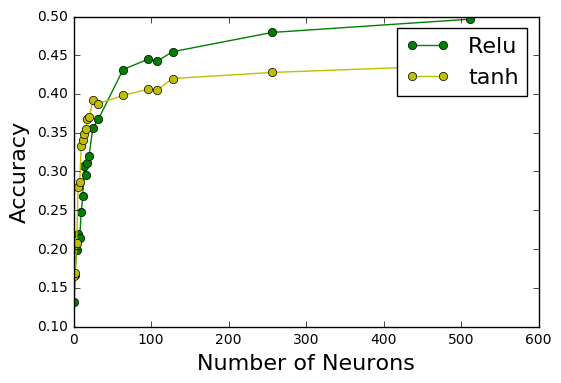

In [37]:
### plt.figure(figsize = (15,10))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(l2, accuracy_values_relu[9::10], 'go-', label = "Relu")
plt.plot([1,2,4,6,8,10,12,14,16,18,20,25,32,64,96,108,128,256,512], accuracy_values[9::10], 'yo-', label = "tanh")

plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend(fontsize=16)

ValueError: x and y must have same first dimension

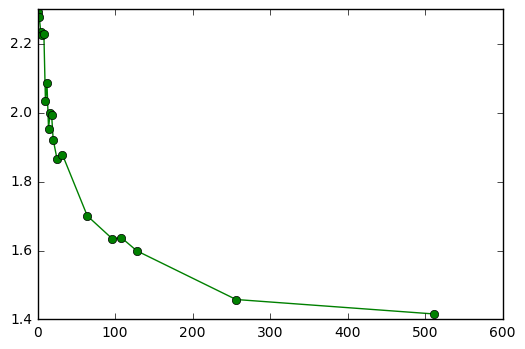

In [63]:
plt.plot(l2, losss_values_relu[9::10], 'go-', label = "Relu")
plt.plot([1,2,4,6,8,10,12,14,16,18,20,25,32,64,96,108,128,256,512], losss_values, 'yo-', label = "tanh")

plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.legend(fontsize=16)

In [41]:
from datetime import datetime
save_model_path = './image_classification'
Train_time_list_10ep_lr=[]
epoch_val_lr=[]
accuracy_values_lr=[]
losss_values_lr = []
print('Training...')
for i in [0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]:
    learning_rate=i
    logits = multilayer_perceptron_relu(x,128)
    model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    with tf.Session() as sess:
        # Initializing the variables
        sess.run(tf.global_variables_initializer())
        start=datetime.now()
        # Training cycle
        for epoch in range(epochs):
            # Loop over all batches
            n_batches = 5
            for batch_i in range(1, n_batches + 1):
                for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                Train_elapse = (datetime.now()-start).total_seconds()
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_stats(sess, batch_features, batch_labels, cost, accuracy)
                print(Train_elapse)
                losss,accuracys=return_stats(sess, batch_features, batch_labels, cost, accuracy)
            losss_values_lr.append(losss)    
            epoch_val_lr.append(epoch)
            accuracy_values_lr.append(accuracys)
            Train_time_list_10ep_lr.append(Train_elapse)
    
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)
    

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:    77.0157 Validation Accuracy: 0.103000
9.315957
Epoch  1, CIFAR-10 Batch 2:  Loss:    26.4078 Validation Accuracy: 0.099800
30.121998
Epoch  1, CIFAR-10 Batch 3:  Loss:    27.7977 Validation Accuracy: 0.094200
40.814289
Epoch  1, CIFAR-10 Batch 4:  Loss:    41.9863 Validation Accuracy: 0.103000
50.823679
Epoch  1, CIFAR-10 Batch 5:  Loss:   127.4724 Validation Accuracy: 0.103000
58.291488
Epoch  2, CIFAR-10 Batch 1:  Loss:    72.8113 Validation Accuracy: 0.099800
65.579796
Epoch  2, CIFAR-10 Batch 2:  Loss:    56.8748 Validation Accuracy: 0.097000
73.265603
Epoch  2, CIFAR-10 Batch 3:  Loss:    43.9168 Validation Accuracy: 0.094200
80.423547
Epoch  2, CIFAR-10 Batch 4:  Loss:    97.4269 Validation Accuracy: 0.102000
87.589513
Epoch  2, CIFAR-10 Batch 5:  Loss:    59.3057 Validation Accuracy: 0.097000
94.891859
Epoch  3, CIFAR-10 Batch 1:  Loss:    45.5196 Validation Accuracy: 0.102000
102.027742
Epoch  3, CIFAR-10 Batch 2:  Loss:    71.6

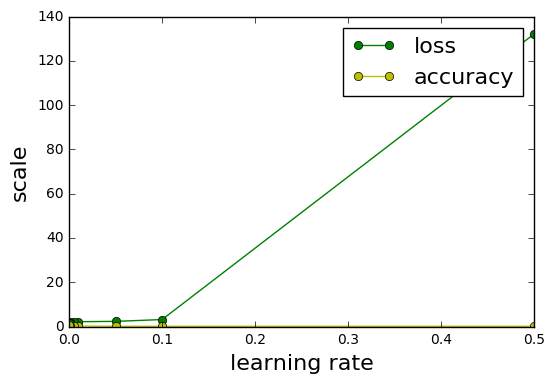

In [44]:
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], losss_values_lr[9::10], 'go-', label = "loss")
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], accuracy_values_lr[9::10], 'yo-', label = "accuracy")

plt.xlabel('learning rate',fontsize=16)
plt.ylabel('scale',fontsize=16)
plt.legend(fontsize=16)

(0, 10)

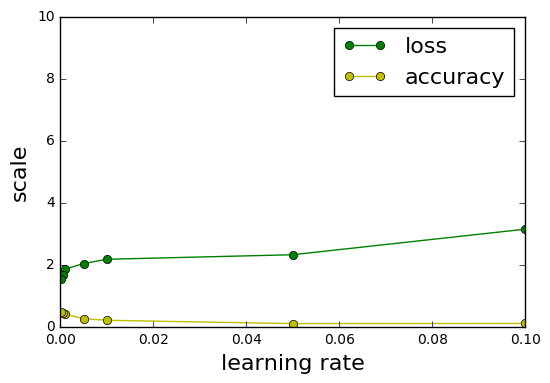

In [47]:
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], losss_values_lr[9::10], 'go-', label = "loss")
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], accuracy_values_lr[9::10], 'yo-', label = "accuracy")

plt.xlabel('learning rate',fontsize=16)
plt.ylabel('scale',fontsize=16)
plt.legend(fontsize=16)
plt.xlim(0, 0.1)
plt.ylim(0, 10)

(0, 3)

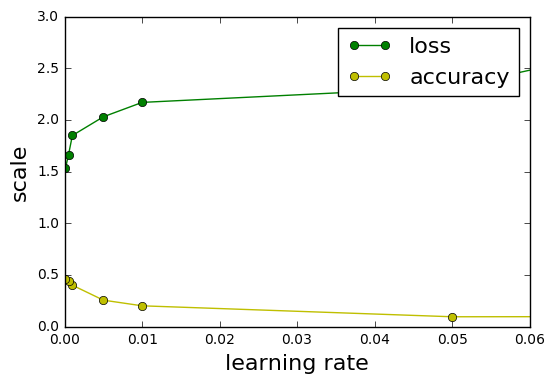

In [48]:
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], losss_values_lr[9::10], 'go-', label = "loss")
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], accuracy_values_lr[9::10], 'yo-', label = "accuracy")

plt.xlabel('learning rate',fontsize=16)
plt.ylabel('scale',fontsize=16)
plt.legend(fontsize=16)
plt.xlim(0, 0.06)
plt.ylim(0, 3)

C:\Users\kcgov\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


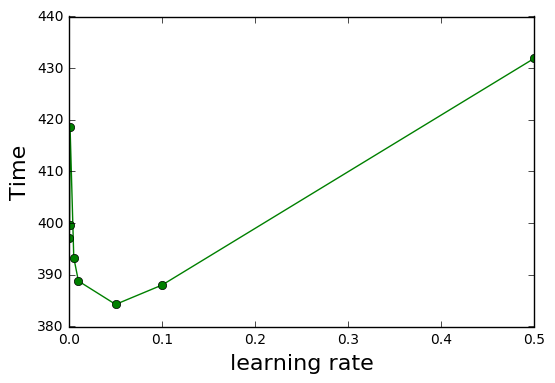

In [51]:
plt.plot([0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], Train_time_list_10ep_lr[9::10], 'go-')


plt.xlabel('learning rate',fontsize=16)
plt.ylabel('Time',fontsize=16)
plt.legend(fontsize=16)

C:\Users\kcgov\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


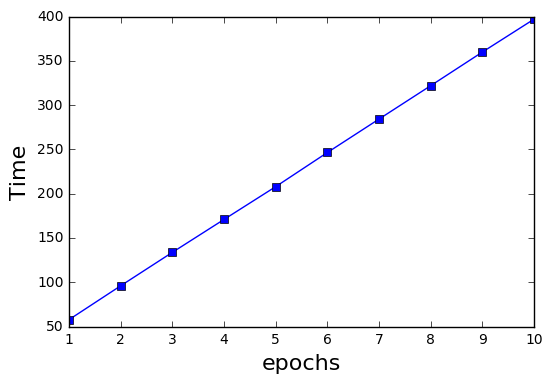

In [67]:

plt.plot([1,2,3,4,5,6,7,8,9,10], Train_time_list_10ep_lr[-10:], 'bs-')


plt.xlabel('epochs',fontsize=16)
plt.ylabel('Time',fontsize=16)
plt.legend(fontsize=16)

<function matplotlib.pyplot.show>

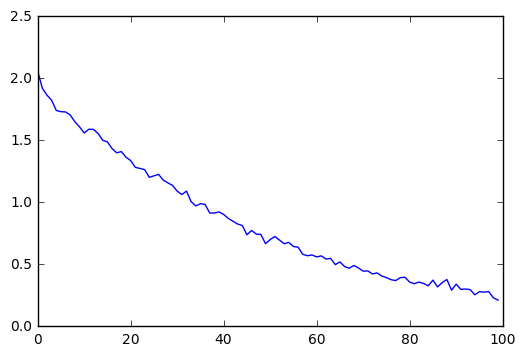

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epoch_val,losss_values)
plt.show

<function matplotlib.pyplot.show>

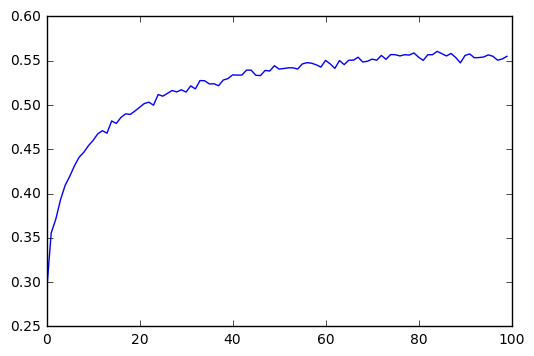

In [182]:
plt.plot(epoch_val,accuracy_values)
plt.show

In [183]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [184]:
import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()
    

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        #random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        #random_test_predictions = sess.run(
         #   tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        #  feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        #display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.5549363057324841



no_hidden_1 = 256
no_hidden_2 = 256
no_input = 3072
no_classes = 10

X = tf.placeholder("float", [None, no_input])
Y = tf.placeholder("float", [None, no_classes])

weights = {
    'h1': tf.Variable(tf.random_normal([no_input, no_hidden_1])),
    'h2': tf.Variable(tf.random_normal([no_hidden_1, no_hidden_2])),
    'out': tf.Variable(tf.random_normal([no_hidden_2, no_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([no_hidden_1])),
    'b2': tf.Variable(tf.random_normal([no_hidden_2])),
    'out': tf.Variable(tf.random_normal([no_classes]))
}

def multilayer_perceptron(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

logits = multilayer_perceptron(X)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_pace)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(features.shape[0]/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = df.train.next_batch(batch_size)
            #batch_x = np.asarray(features[batch_size*(i-1):batch_size*i])
            #batch_y = np.asarray(labels[batch_size*(i-1):batch_size*i])
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                            Y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")
